In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import anndata
import re
import h5py
import scipy.sparse as scs
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csc_matrix
from concurrent.futures import ThreadPoolExecutor, as_completed
import umap
import random
import multiprocessing
random.seed(123)
from joblib import Parallel, delayed
import warnings
import os
from tqdm import tqdm
import math
from PIL import Image, ImageDraw, ImageFont


# QC plots and DEGs

In [3]:
files = os.listdir("h5_by_celltype_clustered/")

/tmp/ipykernel_126645/2213329661.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  output_file = 'Doublet_QC_Plots/'+adata.obs['AIFI_L3'][0]+'.png'
/tmp/ipykernel_126645/2213329661.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  output_file = 'Doublet_QC_Plots/'+adata.obs['AIFI_L3'][0]+'.png'
/tmp/ipykernel_126645/2213329661.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  output_file = 'Doublet_QC_Plots/'+adata.obs['AIFI_L

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


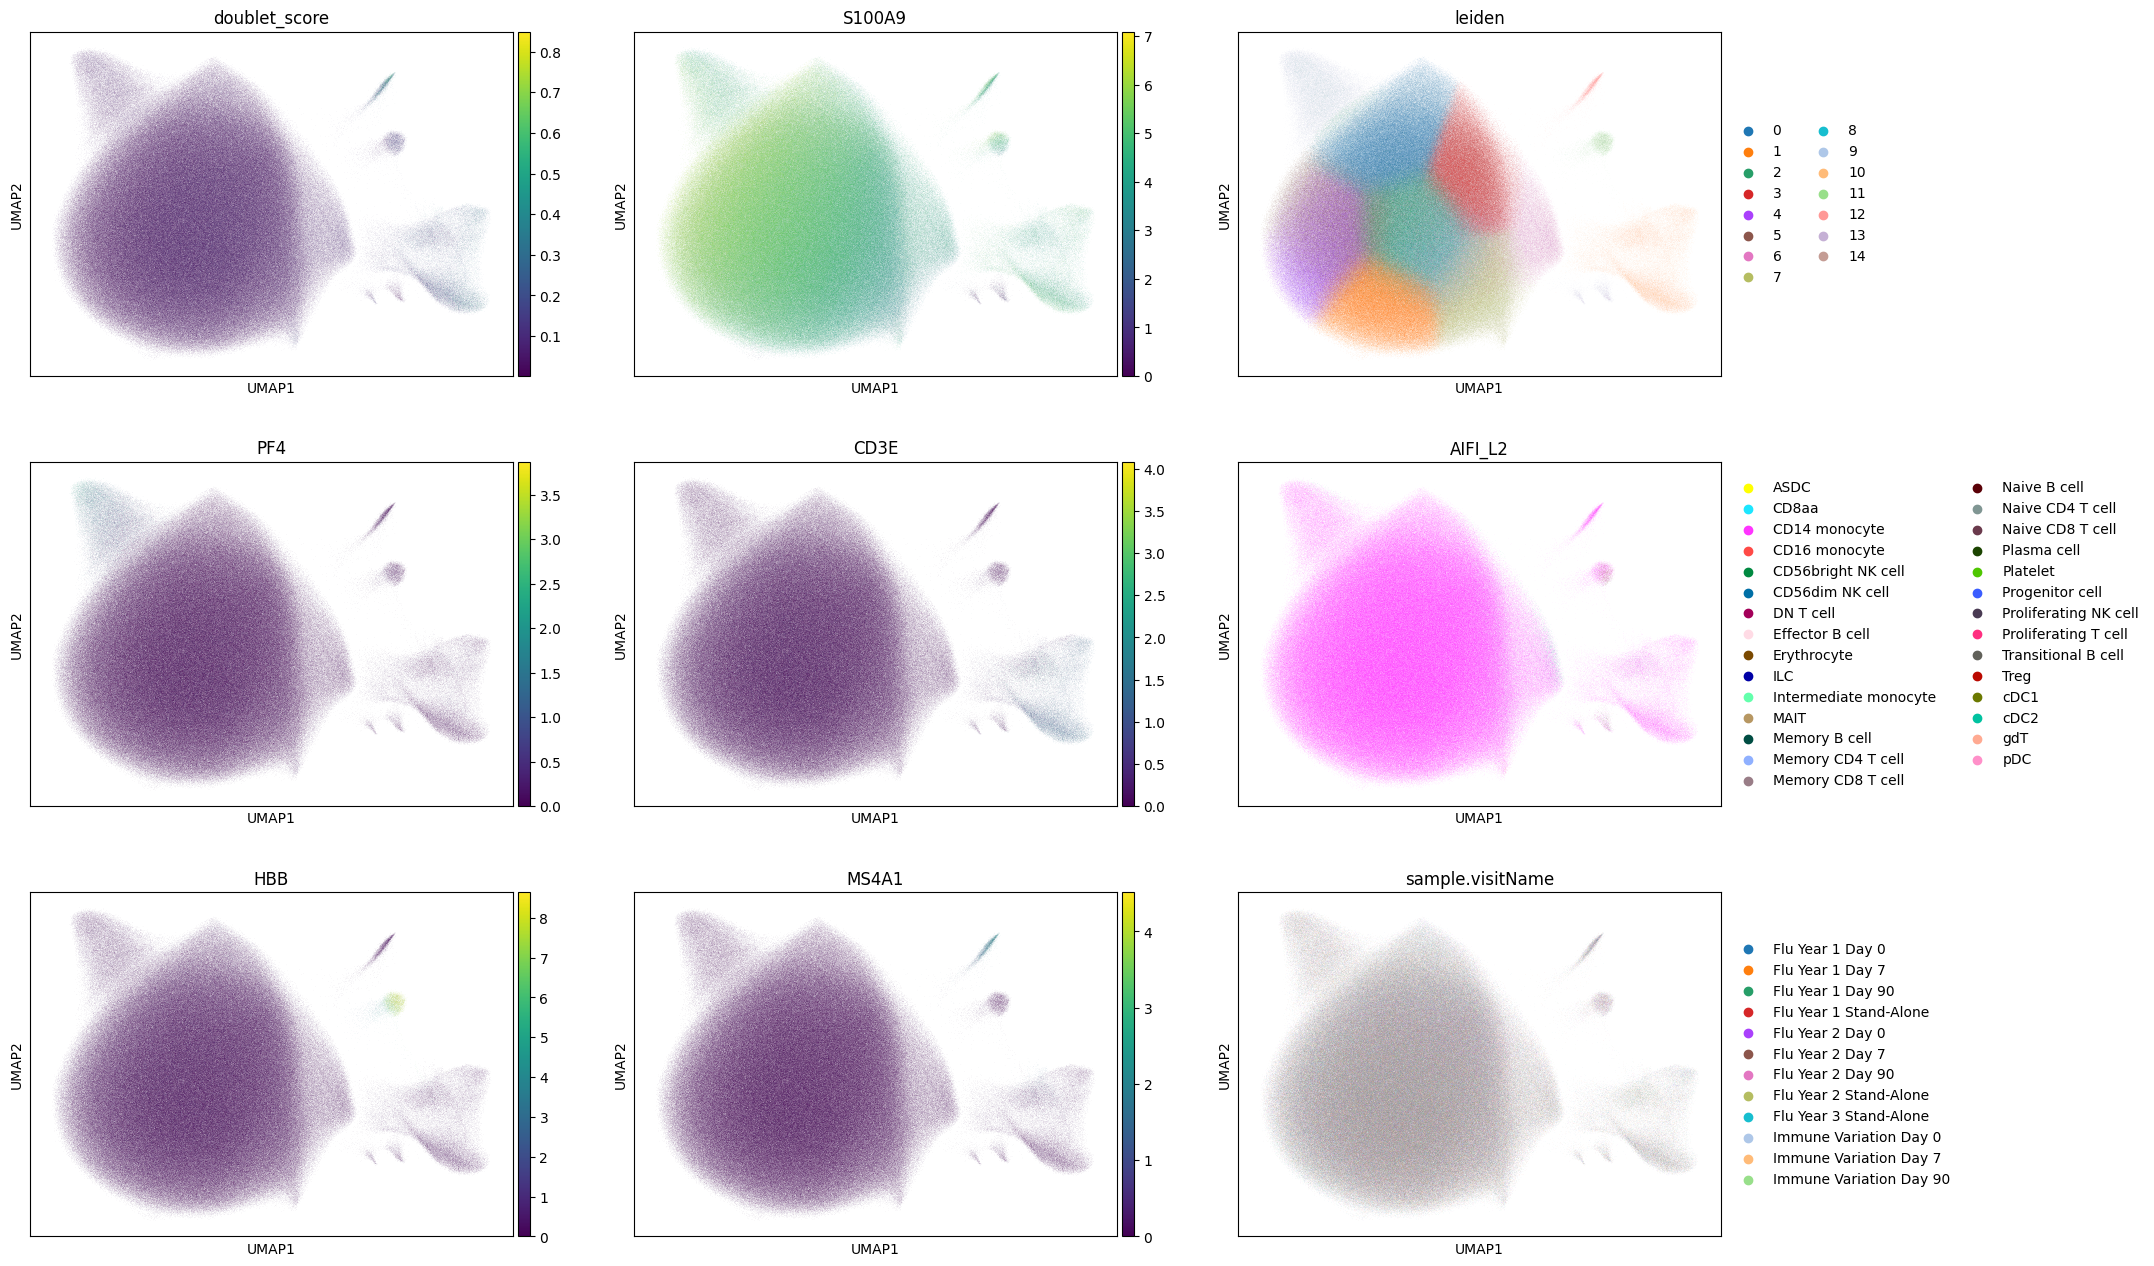

/tmp/ipykernel_126645/2213329661.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby('group').head(20).reset_index(drop=True)
/tmp/ipykernel_126645/2213329661.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby('group')
/tmp/ipykernel_126645/2213329661.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig.suptitle(adata.obs['AIFI_L3'][0], fontsize=50)
/tmp/ipykernel_126645/2213329661.

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


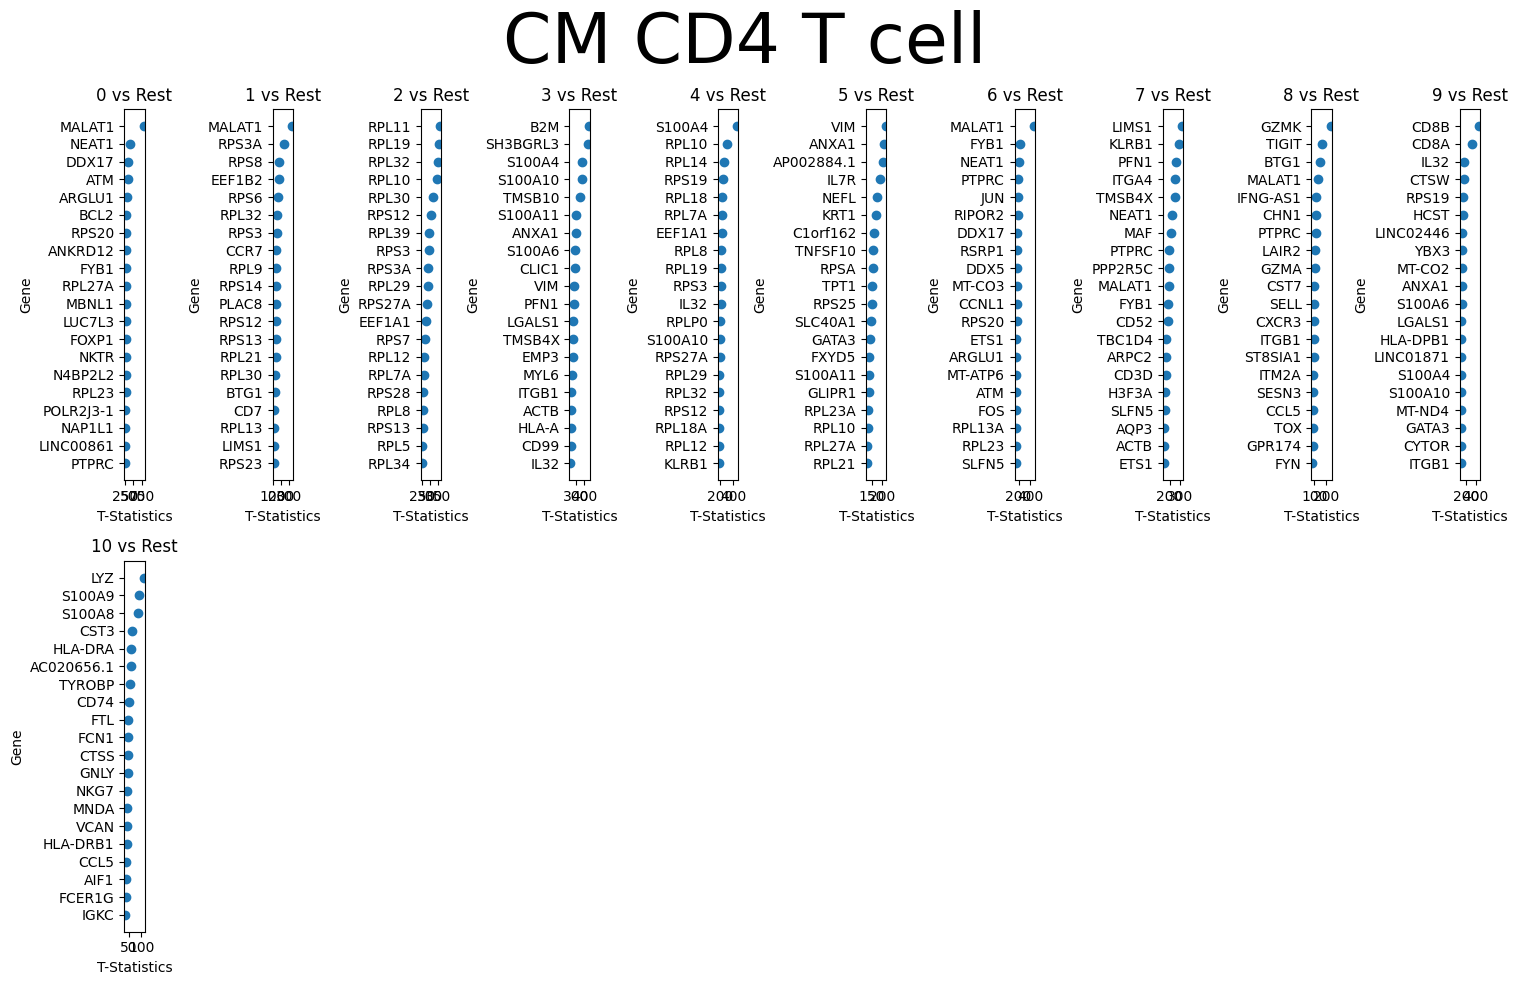

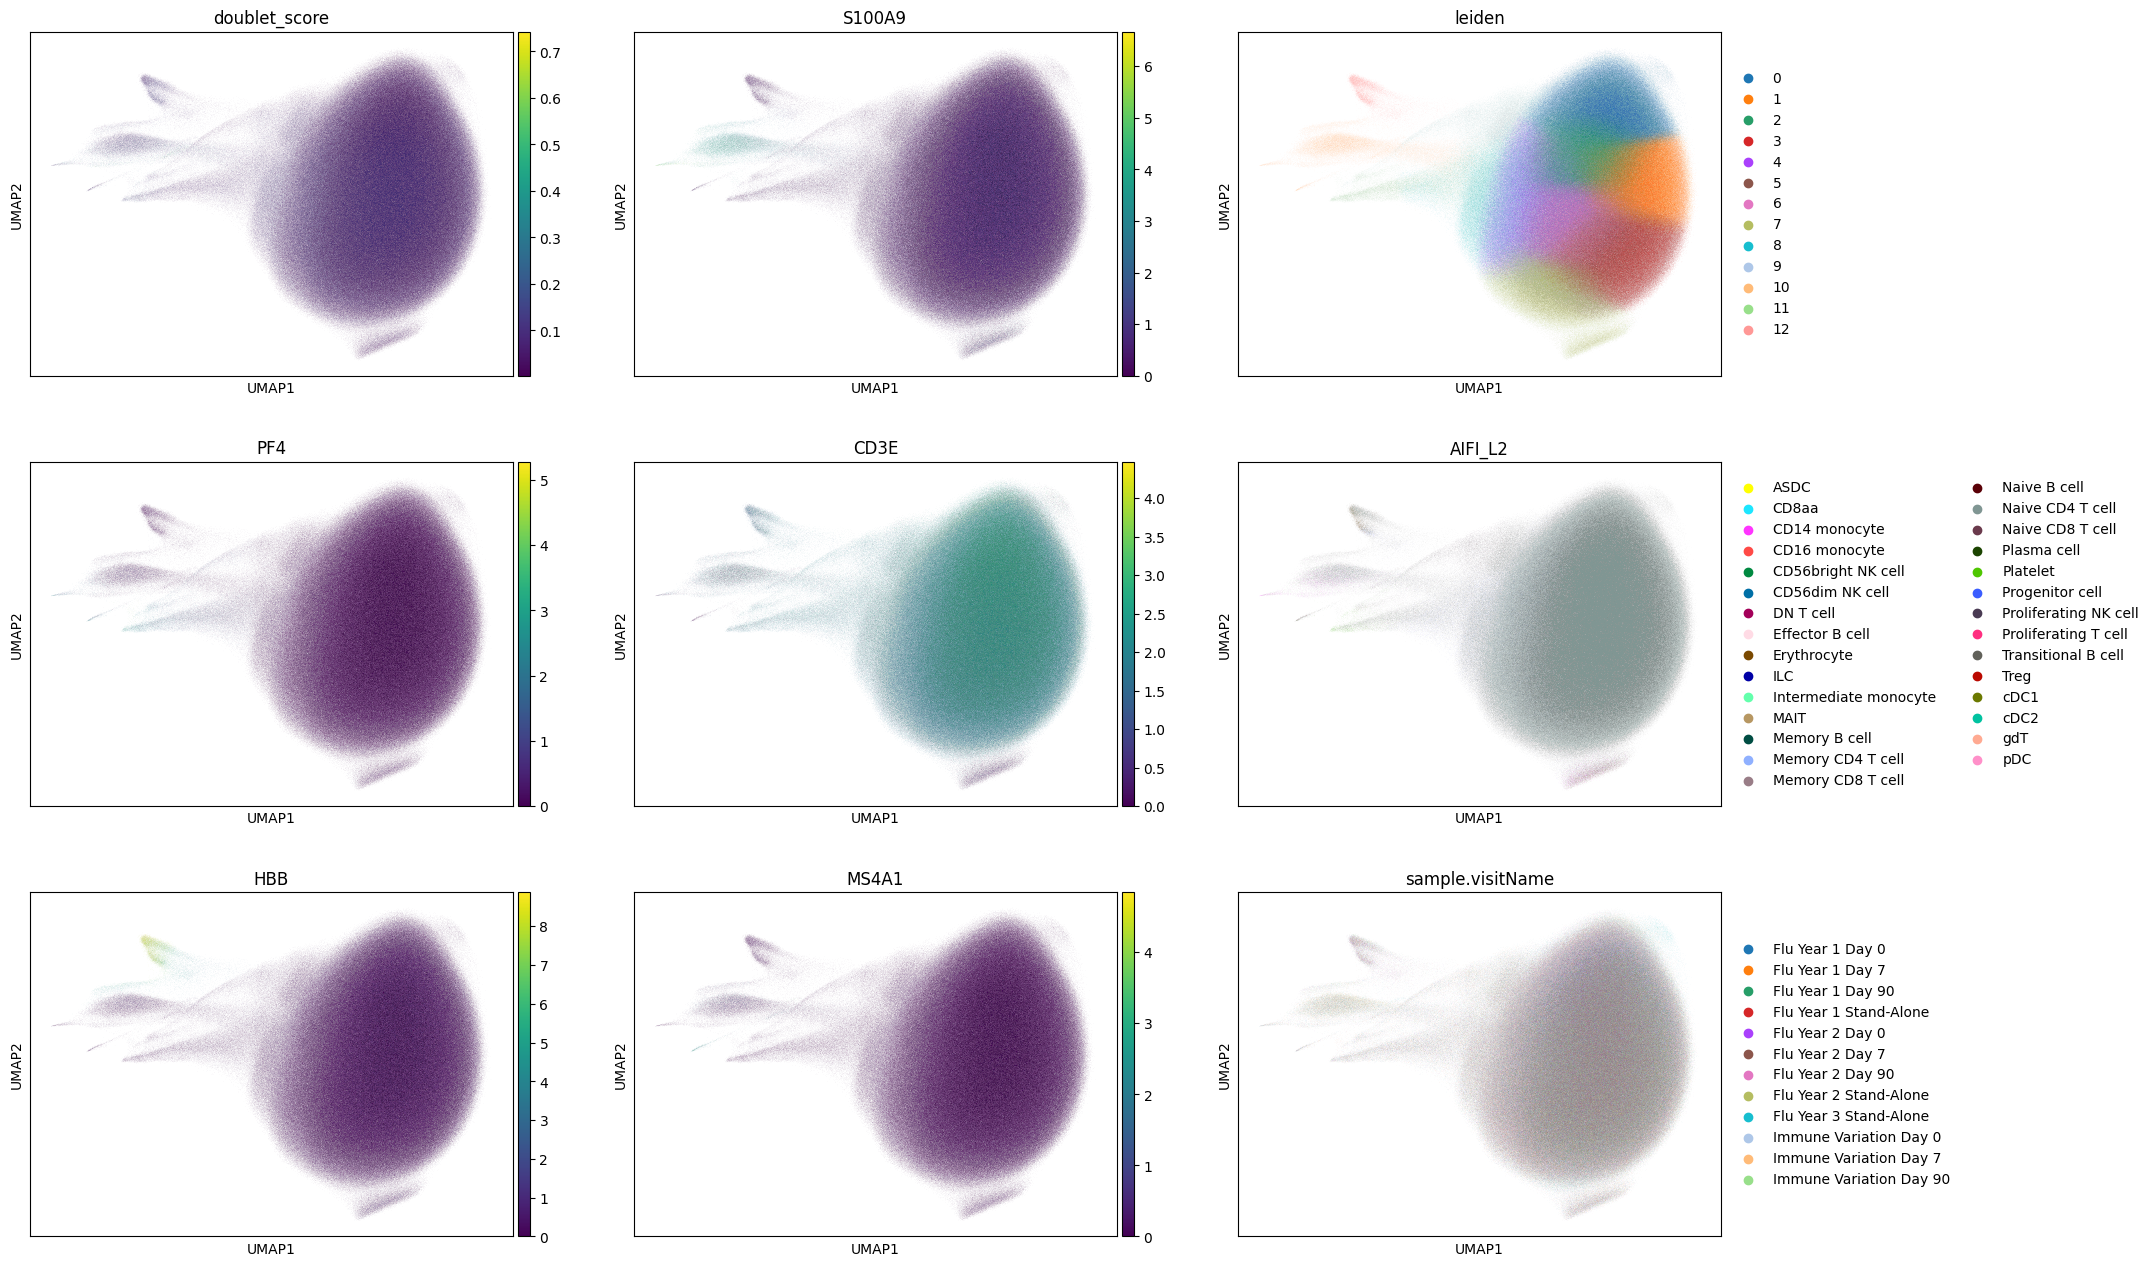

/tmp/ipykernel_126645/2213329661.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby('group').head(20).reset_index(drop=True)
/tmp/ipykernel_126645/2213329661.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby('group')
/tmp/ipykernel_126645/2213329661.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig.suptitle(adata.obs['AIFI_L3'][0], fontsize=50)
/tmp/ipykernel_126645/2213329661.

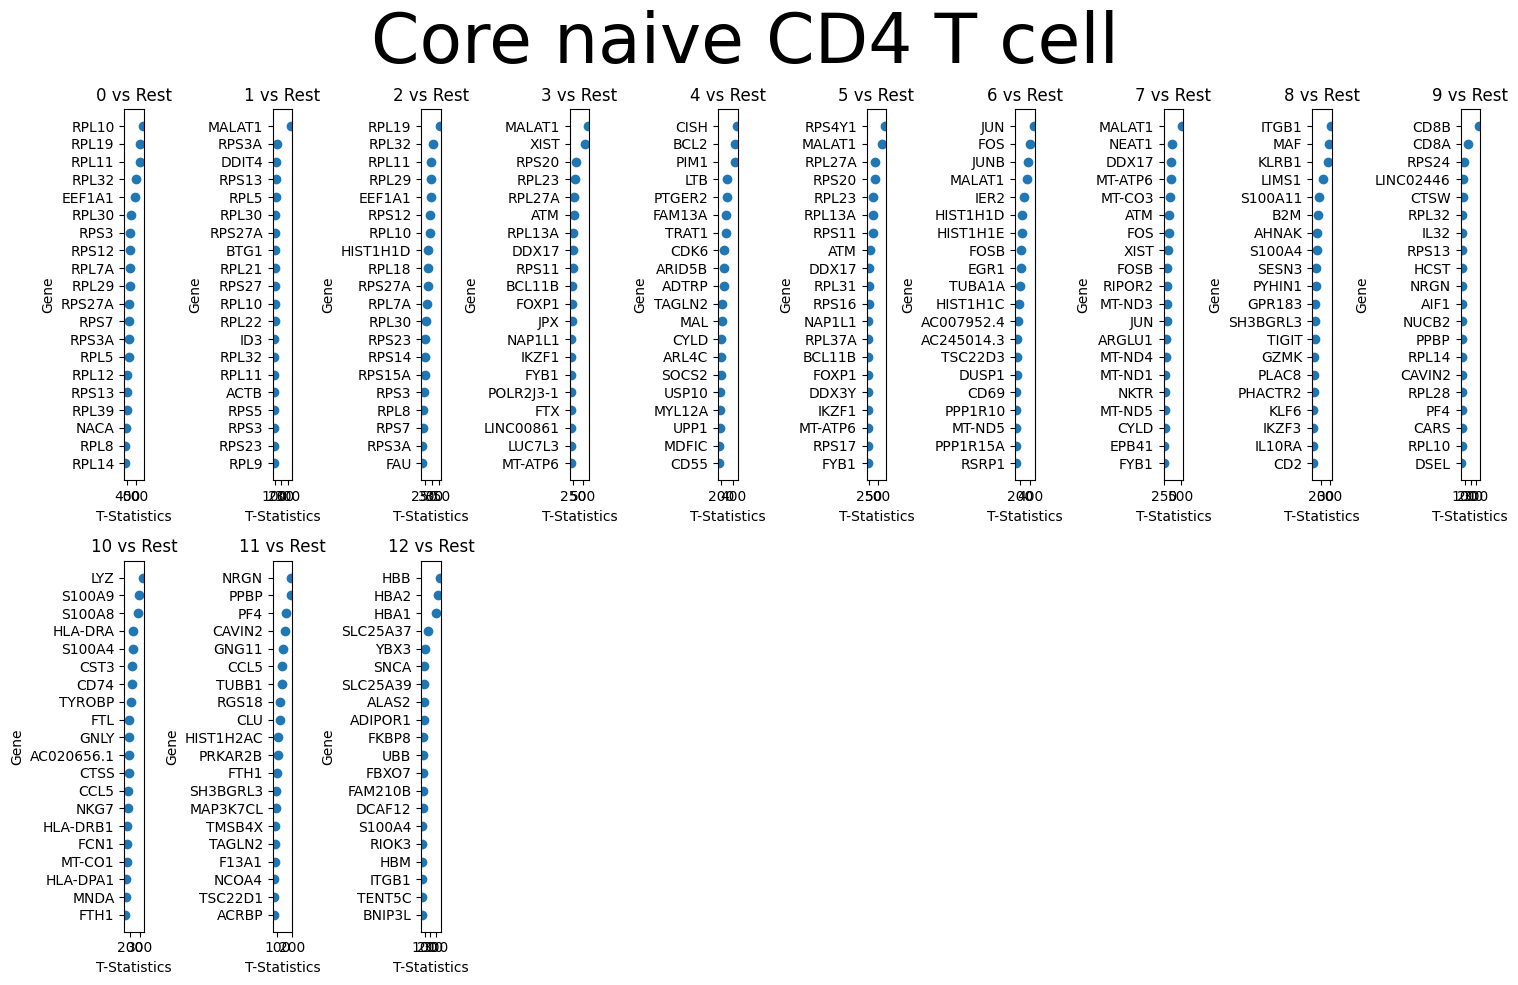

In [26]:
for i in files:
    adata=sc.read_h5ad('h5_by_celltype_clustered/'+i)
    output_file = 'Doublet_QC_Plots/'+adata.obs['AIFI_L3'][0]+'.png'
    if os.path.exists(output_file) and os.path.getsize(output_file) > 0:
        continue 
    sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
    sc.pl.umap(adata, color=['doublet_score', 'S100A9', 'leiden',
                             'PF4', 'CD3E', 'AIFI_L2', 
                             'HBB', 'MS4A1', 'sample.visitName'], ncols=3, save='_UMAP.png')

    df = sc.get.rank_genes_groups_df(adata, group=None)
    df = df.groupby('group').head(20).reset_index(drop=True)
    groups = df.groupby('group')

    n_groups = len(groups)
    n_cols = 10
    n_rows = math.ceil(n_groups / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    fig.suptitle(adata.obs['AIFI_L3'][0], fontsize=50)

    if n_rows == 1:
        axs = axs.reshape(1, -1)

    for ax in axs.flat:
        ax.set_visible(False)

    for i, (name, group) in enumerate(groups):
        row, col = divmod(i, n_cols)
        ax = axs[row, col]
        ax.set_visible(True)
        ax.scatter(group['scores'], group['names'])
        ax.invert_yaxis()
        ax.set_title(str(name) + " vs Rest")
        ax.set_xlabel('T-Statistics')
        ax.set_ylabel('Gene')

    plt.tight_layout()
    plt.savefig('scatter_plots.png')

    img2 = Image.open('figures/umap_UMAP.png')
    img1 = Image.open('scatter_plots.png')

    total_width = max(img1.width, img2.width)
    font_size = 20 
    title_height = font_size * 2  
    total_height = img1.height + img2.height + title_height

    combined_img = Image.new('RGB', (total_width, total_height), 'white')  

    draw = ImageDraw.Draw(combined_img)


    combined_img.paste(img1, (0, title_height))
    combined_img.paste(img2, (0, title_height + img1.height))

    combined_img.save('Doublet_QC_Plots/'+adata.obs['AIFI_L3'][0]+'.png')

### Combine all plots into single pdf

In [28]:
files = os.listdir("Doublet_QC_Plots/")
files.sort()
def pngs_to_pdf(png_files, output_pdf):
    if not png_files:
        print("No PNG files to convert.")
        return

    images = [Image.open(png).convert('RGBA') for png in png_files]

    rgb_images = [Image.new("RGB", image.size, (255, 255, 255)) for image in images]
    for rgb_image, image in zip(rgb_images, images):
        rgb_image.paste(image, mask=image.split()[3])

    rgb_images[0].save(output_pdf, save_all=True, append_images=rgb_images[1:])

png_files = ['Doublet_QC_Plots/'+i for i in files]  
output_pdf = 'output.pdf'  

pngs_to_pdf(png_files, output_pdf)


# Double Check UMAP after removed noise and doublet

In [2]:
files = os.listdir("h5_by_celltype_clustered/")
QC_table=pd.read_csv('BRI Doublet QC - Sheet1.csv')

In [3]:
QC_table = QC_table[~QC_table['Notes'].str.contains('\?', regex=True)]

In [4]:
import re

In [5]:
files.sort()

In [ ]:

def process_and_plot_file(file, QC_table):
    AIFI_L3 = re.sub('.h5ad', '', file)
    print(AIFI_L3)
    output_file = 'Doublet_QC_Plots_filtered/' + AIFI_L3 + '_filtered.png'
    if os.path.exists(output_file) and os.path.getsize(output_file) > 0:
        return 
    adata = sc.read_h5ad('h5_by_celltype_clustered/' + file)

    filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
    adata_cleaned = adata[~adata.obs['leiden'].isin([str(i) for i in filtered_leiden])]

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    sc.pl.umap(adata, color=['leiden'], legend_loc='on data', 
               title=AIFI_L3+'-leiden_unfiltered', ax=axs[0], show=False)
    sc.pl.umap(adata_cleaned, color=['leiden'], legend_loc='on data', 
               title=AIFI_L3+'-leiden_filtered', ax=axs[1], show=False)

    plt.tight_layout()
    plt.savefig('Doublet_QC_Plots_filtered/' + AIFI_L3 + '_filtered.png')
    plt.close()

with concurrent.futures.ProcessPoolExecutor(max_workers=10) as executor:
    results = executor.map(process_and_plot_file, files, [QC_table]*len(files))

Activated memory B cellASDCAdaptive NK cellC1Q+ CD16 monocyteBaEoMaP cellCD14+ cDC2CD27+ effector B cellCD4 MAITCD27- effector B cellCD56bright NK cell









CD8 MAITCD8aaCD95 memory B cellCLP cellCM CD4 T cell
Core CD14 monocyteCM CD8 T cellCore memory B cellCMP cellCore CD16 monocyte




Core naive B cell




Core naive CD8 T cell Core naive CD4 T cellEarly memory B cellGZMB+ Vd2 gdTDN T cell
ErythrocyteGZMB- CD27+ EM CD4 T cellGZMB- CD27- EM CD4 T cell
GZMK+ CD56dim NK cellGZMK+ CD27+ EM CD8 T cell









/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

GZMK+ Vd2 gdT


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

GZMK+ memory CD4 Treg


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

GZMK- CD27+ EM CD8 T cell


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

GZMK- CD56dim NK cell


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

HLA-DRhi cDC2


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

IL1B+ CD14 monocyte


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

ILC


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

ISG+ CD14 monocyte


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

ISG+ CD16 monocyte


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

ISG+ CD56dim NK cell


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/py

ISG+ MAIT


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'c

ISG+ cDC2


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

ISG+ memory CD4 T cell


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

ISG+ memory CD8 T cell


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

ISG+ naive B cell


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

ISG+ naive CD4 T cell


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

ISG+ naive CD8 T cell


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

Intermediate monocyte


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

KLRB1+ memory CD4 Treg


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

KLRB1+ memory CD8 Treg


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

KLRF1+ GZMB+ CD27- EM CD8 T cell


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

KLRF1+ effector Vd1 gdT


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

KLRF1- GZMB+ CD27- EM CD8 T cell


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

KLRF1- GZMB+ CD27- memory CD4 T cell


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

KLRF1- effector Vd1 gdT


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

Memory CD4 Treg


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

Memory CD8 Treg


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positio

Naive CD4 Treg


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Naive Vd1 gdT
Plasma cell


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

Platelet


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

Proliferating NK cell


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

Proliferating T cell


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

SOX4+ Vd1 gdT


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/

SOX4+ naive CD4 T cell


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


SOX4+ naive CD8 T cell


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

Transitional B cell


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()


Type 2 polarized memory B cell


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is depre

cDC1


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

pDC


/tmp/ipykernel_10080/151794349.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value o

In [45]:
files = os.listdir("Doublet_QC_Plots_filtered/")
files.sort()
def pngs_to_pdf(png_files, output_pdf):
    if not png_files:
        print("No PNG files to convert.")
        return

    images = [Image.open(png).convert('RGBA') for png in png_files]

    rgb_images = [Image.new("RGB", image.size, (255, 255, 255)) for image in images]
    for rgb_image, image in zip(rgb_images, images):
        rgb_image.paste(image, mask=image.split()[3])

    rgb_images[0].save(output_pdf, save_all=True, append_images=rgb_images[1:])

png_files = ['Doublet_QC_Plots_filtered/'+i for i in files]  
output_pdf = 'Leiden_UMAP_after_cleaning.pdf'  

pngs_to_pdf(png_files, output_pdf)

In [28]:
adata = sc.read_h5ad('h5_by_celltype_clustered/' + 'SOX4+ naive CD4 T cell.h5ad')

filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
adata_cleaned = adata[~adata.obs['leiden'].isin([str(i) for i in filtered_leiden])]

/tmp/ipykernel_683/1428626963.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [6]:
adata_cleaned = adata[adata.obs['leiden'].isin(['7'])]

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [7]:
adata_cleaned.obs['AIFI_L2'].value_counts()

AIFI_L2
Memory CD8 T cell     1698
gdT                   1519
Naive CD8 T cell      1111
Memory CD4 T cell      387
Naive CD4 T cell       346
CD8aa                  225
Treg                   120
DN T cell                8
MAIT                     3
CD56bright NK cell       2
Erythrocyte              1
ILC                      1
Memory B cell            1
Platelet                 1
Name: count, dtype: int64

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

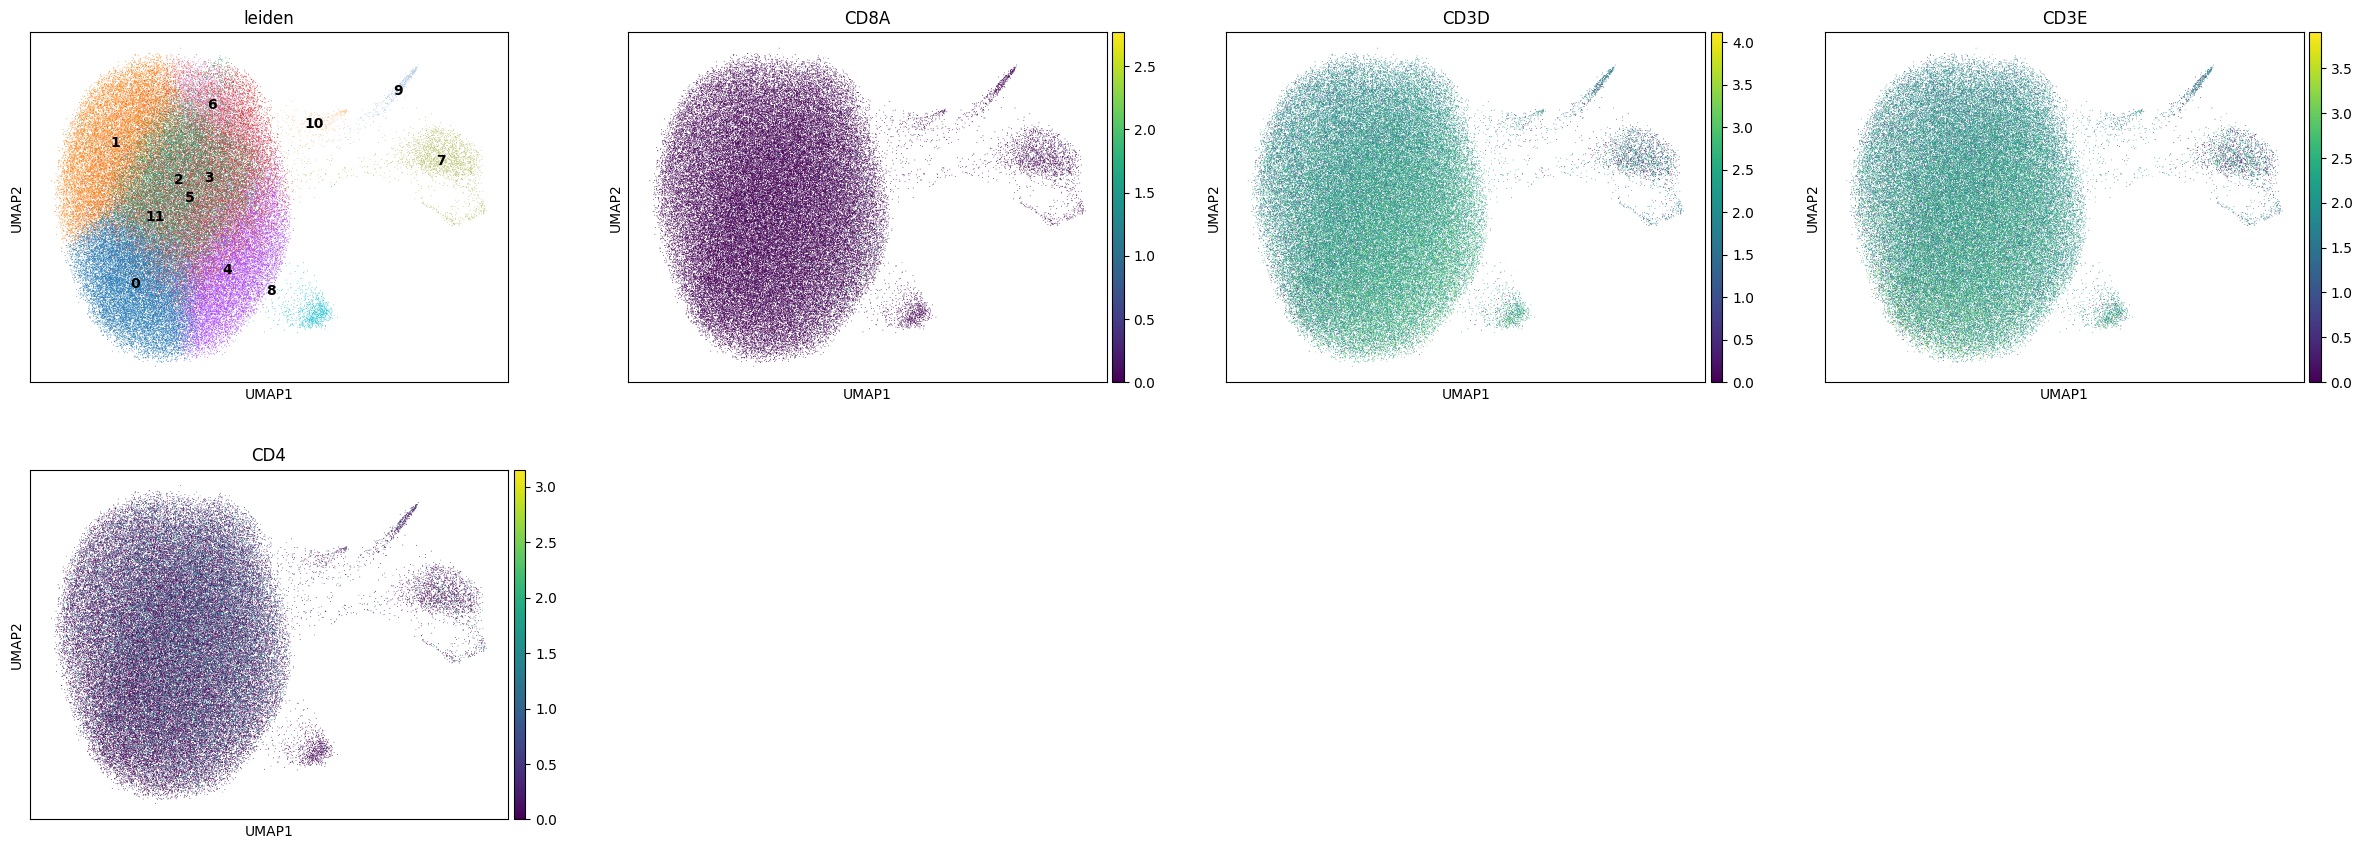

In [30]:
sc.pl.umap(adata, color=['leiden','CD8A','CD3D','CD3E','CD4'], legend_loc='on data')

# Split Cleaned Object into h5ad by samples

In [ ]:
file=files[0]
AIFI_L3 = re.sub('.h5ad', '', file)
print(AIFI_L3)
output_file = 'Doublet_QC_Plots_filtered/' + AIFI_L3 + '_filtered.png'
if os.path.exists(output_file) and os.path.getsize(output_file) > 0:
    return 
adata = sc.read_h5ad('h5_by_celltype_clustered/' + file)

filtered_leiden = QC_table[QC_table['AIFI_L3'] == adata.obs['AIFI_L3'][0]]['leiden'].tolist()
adata_cleaned = adata[~adata.obs['leiden'].isin([str(i) for i in filtered_leiden])]